In [1]:
# import of necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Tuple, Any, Dict, List
import json
import pandas as pd

In [2]:
# google colab handling
from google.colab import drive, files
drive.mount('/content/drive')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  1


In [3]:
# CONSTANTS
SEED: int = 42
INPUT_SHAPE: Tuple[int] = (144, 144, 1)
BATCH_SIZE: int = 32
IMAGES_PATH: str = "/content/drive/MyDrive/STUDIA/WDSN/Project/images/processed"
LABELS_PATH: str = "/content/drive/MyDrive/STUDIA/WDSN/Project/images/labels/labels.json"
MODELS_DIR: str = '/content/drive/MyDrive/STUDIA/WDSN/Project/models'

In [4]:
# functions

def compare_history(
    histories: List[Dict[str, Any]], 
    labels: List[str], 
    epochs: List[int], 
    metric: str = 'MAE'
    ) -> None:
    plt.figure()
    for history, label, epoch in zip(histories, labels, epochs):
        plt.plot(range(epoch), history.history['mean_absolute_error'], label=label+" train")
        plt.plot(range(epoch), history.history['val_mean_absolute_error'], label=label+" validation")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
# data load
dataset: pd.DataFrame = pd.read_json(LABELS_PATH).T
dataset["filename"] = dataset.index

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=0.1,
      rescale=1./255.,
      horizontal_flip=True,
      vertical_flip=True,
  ).flow_from_dataframe(
      dataset,
      directory=IMAGES_PATH,
      x_col='filename',
      y_col='mean',
      weight_col="weight",
      color_mode = "grayscale",
      batch_size=BATCH_SIZE,
      target_size=INPUT_SHAPE[:2],
      subset="training",
      class_mode="raw",
      shuffle=True,
  )


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=0.1,
      rescale=1./255.,
  ).flow_from_dataframe(
      dataset,
      directory=IMAGES_PATH,
      x_col='filename',
      y_col='mean',
      weight_col="weight",
      color_mode = "grayscale",
      batch_size=BATCH_SIZE,
      target_size=INPUT_SHAPE[:2],
      subset="validation",
      class_mode="raw",
      shuffle=True,
  )

Found 8548 validated image filenames.
Found 949 validated image filenames.


# Model selection

In [ ]:
# model proposal

model: tf.keras.models.Model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [ ]:
# model training

history = model.fit(
    train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=valid_generator
    )

Epoch 1/15
238/238 [==============================] - 2436s 10s/step - loss: 7.0230 - mean_squared_error: 0.8691 - mean_absolute_error: 0.6917 - val_loss: 3.0324 - val_mean_squared_error: 0.3586 - val_mean_absolute_error: 0.4601
Epoch 2/15
238/238 [==============================] - 178s 748ms/step - loss: 4.3248 - mean_squared_error: 0.4822 - mean_absolute_error: 0.5424 - val_loss: 2.8975 - val_mean_squared_error: 0.3423 - val_mean_absolute_error: 0.4489
Epoch 3/15
238/238 [==============================] - 183s 771ms/step - loss: 3.9376 - mean_squared_error: 0.4533 - mean_absolute_error: 0.5249 - val_loss: 6.0075 - val_mean_squared_error: 0.4995 - val_mean_absolute_error: 0.5963
Epoch 4/15
238/238 [==============================] - 176s 736ms/step - loss: 4.1085 - mean_squared_error: 0.4555 - mean_absolute_error: 0.5264 - val_loss: 2.9539 - val_mean_squared_error: 0.4785 - val_mean_absolute_error: 0.5366
Epoch 5/15
238/238 [==============================] - 177s 745ms/step - loss: 3.9

In [ ]:
# train visualization
compare_history([history], ["base model"], [15])

NameError: ignored

In [ ]:

model_deeper: tf.keras.models.Model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(11, 11), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_deeper.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [ ]:
history_deeper = model_deeper.fit(
    train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=valid_generator
    )

Epoch 1/30
268/268 [==============================] - 7847s 29s/step - loss: 7.4221 - mean_squared_error: 1.0089 - mean_absolute_error: 0.7646 - val_loss: 3.2322 - val_mean_squared_error: 0.5015 - val_mean_absolute_error: 0.5504
Epoch 2/30
268/268 [==============================] - 27s 100ms/step - loss: 3.9150 - mean_squared_error: 0.4710 - mean_absolute_error: 0.5376 - val_loss: 2.9306 - val_mean_squared_error: 0.3075 - val_mean_absolute_error: 0.4353
Epoch 3/30
268/268 [==============================] - 26s 99ms/step - loss: 3.8368 - mean_squared_error: 0.4400 - mean_absolute_error: 0.5190 - val_loss: 2.8162 - val_mean_squared_error: 0.4163 - val_mean_absolute_error: 0.4973
Epoch 4/30
268/268 [==============================] - 27s 100ms/step - loss: 3.7435 - mean_squared_error: 0.4306 - mean_absolute_error: 0.5144 - val_loss: 2.7166 - val_mean_squared_error: 0.3307 - val_mean_absolute_error: 0.4471
Epoch 5/30
268/268 [==============================] - 26s 99ms/step - loss: 3.5956 - 

In [ ]:
# layers in model shown

In [ ]:
model_deeper: tf.keras.models.Model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(11, 11), activation='elu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='elu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_deeper.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [ ]:
history_deeper = model_deeper.fit(
    train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=valid_generator
    )

Epoch 1/15
268/268 [==============================] - 2008s 7s/step - loss: 0.6369 - mean_squared_error: 0.6356 - mean_absolute_error: 0.5817 - val_loss: 0.3000 - val_mean_squared_error: 0.2999 - val_mean_absolute_error: 0.4357
Epoch 2/15
268/268 [==============================] - 330s 1s/step - loss: 0.3706 - mean_squared_error: 0.3704 - mean_absolute_error: 0.4797 - val_loss: 0.2997 - val_mean_squared_error: 0.3003 - val_mean_absolute_error: 0.4387
Epoch 3/15
268/268 [==============================] - 329s 1s/step - loss: 0.3716 - mean_squared_error: 0.3722 - mean_absolute_error: 0.4794 - val_loss: 0.2983 - val_mean_squared_error: 0.2997 - val_mean_absolute_error: 0.4382
Epoch 4/15
268/268 [==============================] - 328s 1s/step - loss: 0.3651 - mean_squared_error: 0.3666 - mean_absolute_error: 0.4769 - val_loss: 0.3240 - val_mean_squared_error: 0.3232 - val_mean_absolute_error: 0.4655
Epoch 5/15
268/268 [==============================] - 334s 1s/step - loss: 0.3658 - mean_sq

In [ ]:
model_deeper.save(os.path.join(MODELS_DIR, "wide_model_full.h5"))

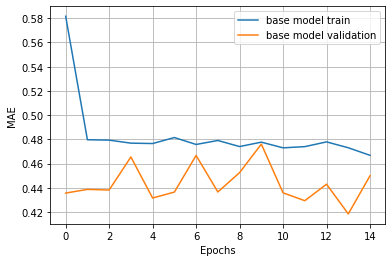

In [ ]:
compare_history([history_deeper], ["base model"], [15])

In [ ]:
model_deeper = tf.keras.models.load_model(os.path.join(MODELS_DIR, "wide_model_full.h5"), compile=False, options = None)

In [ ]:
model_deeper.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [ ]:
history_deeper = model_deeper.fit(
    train_generator, 
    epochs=30, 
    batch_size=BATCH_SIZE,
    validation_data=valid_generator
    )

Epoch 1/30
268/268 [==============================] - 7872s 29s/step - loss: 3.5106 - mean_squared_error: 0.3923 - mean_absolute_error: 0.4900 - val_loss: 2.7684 - val_mean_squared_error: 0.2853 - val_mean_absolute_error: 0.4185
Epoch 2/30
268/268 [==============================] - 32s 121ms/step - loss: 3.4913 - mean_squared_error: 0.3973 - mean_absolute_error: 0.4931 - val_loss: 2.7240 - val_mean_squared_error: 0.2917 - val_mean_absolute_error: 0.4234
Epoch 3/30
268/268 [==============================] - 32s 120ms/step - loss: 3.5473 - mean_squared_error: 0.3998 - mean_absolute_error: 0.4955 - val_loss: 2.9422 - val_mean_squared_error: 0.2789 - val_mean_absolute_error: 0.4169
Epoch 4/30
268/268 [==============================] - 32s 120ms/step - loss: 3.4960 - mean_squared_error: 0.3845 - mean_absolute_error: 0.4850 - val_loss: 2.8749 - val_mean_squared_error: 0.4591 - val_mean_absolute_error: 0.5312
Epoch 5/30
268/268 [==============================] - 32s 121ms/step - loss: 3.5514 

In [ ]:
model_deeper.save(os.path.join(MODELS_DIR, "wide_model_full_long_train.h5"))

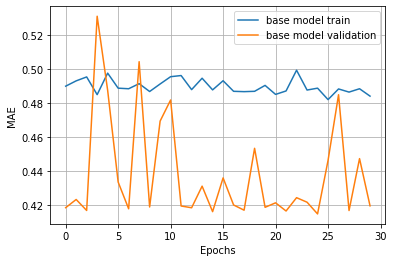

In [ ]:
compare_history([history_deeper], ["base model"], [30])

In [ ]:
pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 6.6 MB/s eta 0:00:00


In [ ]:
import tf_keras_vis
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [ ]:
model_deeper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 16)      1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                        

20/20 [==============================] - 0s 20ms/step - Score: -278.9789 - TotalVariation2D: 21.4281 - Norm: 15.9547


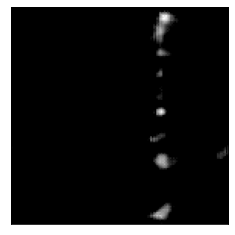

20/20 [==============================] - 0s 20ms/step - Score: -190.3587 - TotalVariation2D: 31.7714 - Norm: 16.9561


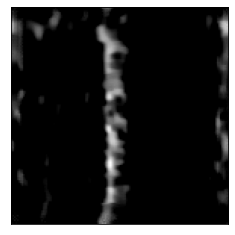

20/20 [==============================] - 0s 20ms/step - Score: -322.4242 - TotalVariation2D: 19.1750 - Norm: 18.6944


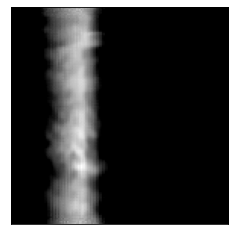

20/20 [==============================] - 0s 19ms/step - Score: -305.5699 - TotalVariation2D: 18.9625 - Norm: 18.1411


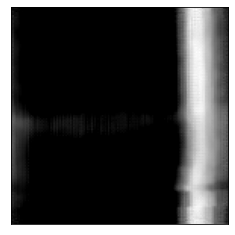

20/20 [==============================] - 0s 20ms/step - Score: -377.2589 - TotalVariation2D: 19.3483 - Norm: 23.5566


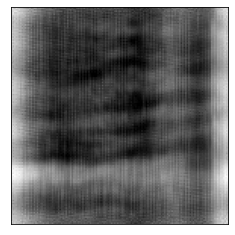

20/20 [==============================] - 0s 20ms/step - Score: 20.9086 - TotalVariation2D: 22.0413 - Norm: 16.6019


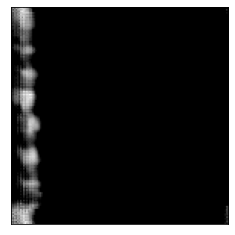

20/20 [==============================] - 0s 21ms/step - Score: -95.0975 - TotalVariation2D: 30.0970 - Norm: 19.3342


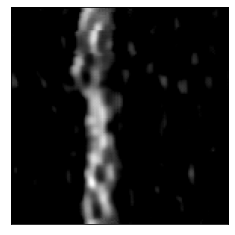

20/20 [==============================] - 0s 21ms/step - Score: -374.0567 - TotalVariation2D: 21.7776 - Norm: 15.4727


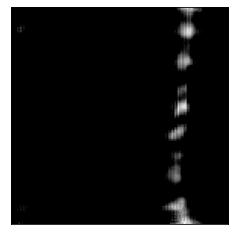

20/20 [==============================] - 0s 21ms/step - Score: -487.3705 - TotalVariation2D: 23.2039 - Norm: 16.2637


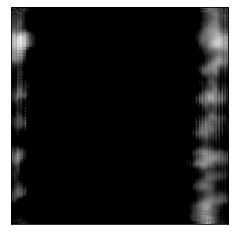

20/20 [==============================] - 0s 21ms/step - Score: -403.0794 - TotalVariation2D: 20.1423 - Norm: 15.8415


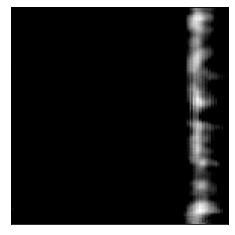

20/20 [==============================] - 0s 22ms/step - Score: -372.4345 - TotalVariation2D: 28.6504 - Norm: 14.7699


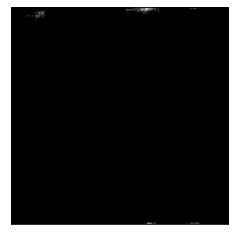

20/20 [==============================] - 0s 21ms/step - Score: 261.9668 - TotalVariation2D: 30.4562 - Norm: 16.5513


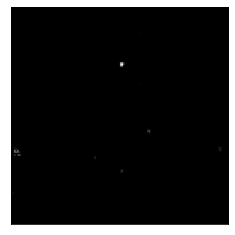

20/20 [==============================] - 0s 21ms/step - Score: -220.8814 - TotalVariation2D: 24.5079 - Norm: 15.5023


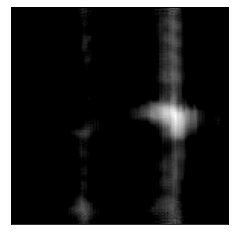

20/20 [==============================] - 0s 21ms/step - Score: -98.8292 - TotalVariation2D: 18.8245 - Norm: 17.4216


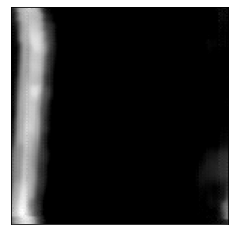

20/20 [==============================] - 0s 21ms/step - Score: -486.3878 - TotalVariation2D: 22.2612 - Norm: 16.7752


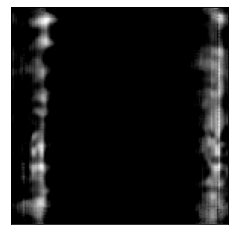

20/20 [==============================] - 0s 21ms/step - Score: -376.4649 - TotalVariation2D: 25.6912 - Norm: 15.7807


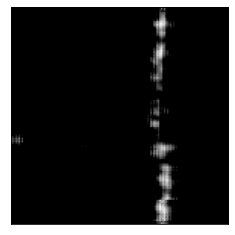

In [ ]:
activation_maximization = ActivationMaximization(
    model_deeper,
    model_modifier=[ExtractIntermediateLayer('conv2d_1'),ReplaceToLinear()],
    clone=False)
for idx in range(16):
  activations = activation_maximization(
      CategoricalScore(idx),
      steps=20,
      input_modifiers=[Jitter(jitter=16), Rotate2D(degree=1)],
      regularizers=[TotalVariation2D(weight=1.0),
                    Norm(weight=0.3, p=1)],
      optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
      callbacks=[Progress()])
  plt.imshow(activations[0][:,:,0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()

100/100 [==============================] - 2s 19ms/step - Score: -1.9728 - TotalVariation2D: 7.4774 - Norm: 10.5779


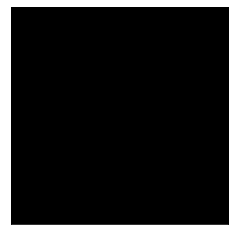

100/100 [==============================] - 2s 18ms/step - Score: 123.7478 - TotalVariation2D: 7.4149 - Norm: 26.1877


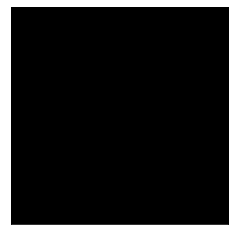

100/100 [==============================] - 2s 19ms/step - Score: 46.9585 - TotalVariation2D: 7.1757 - Norm: 17.4865


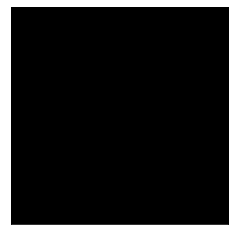

100/100 [==============================] - 2s 18ms/step - Score: 28.3424 - TotalVariation2D: 7.9180 - Norm: 35.4316


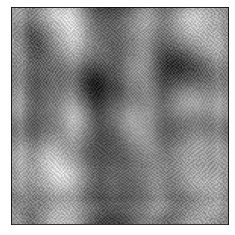

100/100 [==============================] - 2s 19ms/step - Score: 127.0861 - TotalVariation2D: 7.2947 - Norm: 26.5524


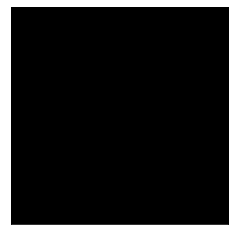

100/100 [==============================] - 2s 19ms/step - Score: 102.4509 - TotalVariation2D: 8.5951 - Norm: 50.3800


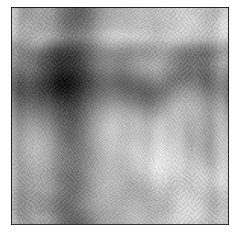

100/100 [==============================] - 2s 19ms/step - Score: -8.3051 - TotalVariation2D: 8.7837 - Norm: 21.9226


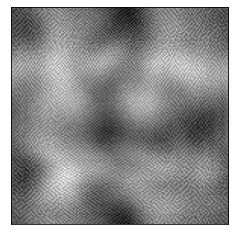

100/100 [==============================] - 2s 20ms/step - Score: 45.7759 - TotalVariation2D: 7.5926 - Norm: 40.9109


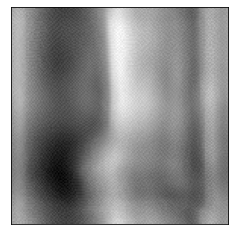

100/100 [==============================] - 2s 19ms/step - Score: 824.3480 - TotalVariation2D: 5.9245 - Norm: 57.8474


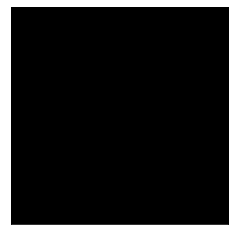

100/100 [==============================] - 2s 20ms/step - Score: 149.9822 - TotalVariation2D: 7.4664 - Norm: 57.1831


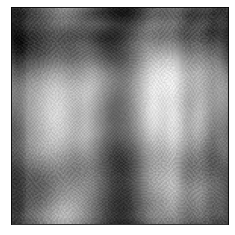

100/100 [==============================] - 2s 20ms/step - Score: 827.7520 - TotalVariation2D: 5.8295 - Norm: 57.4572


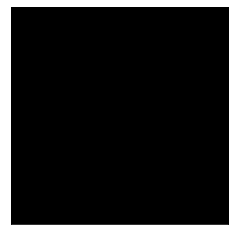

100/100 [==============================] - 2s 19ms/step - Score: -2.6605 - TotalVariation2D: 7.4988 - Norm: 10.3104


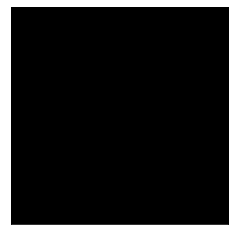

100/100 [==============================] - 2s 20ms/step - Score: 7.4739 - TotalVariation2D: 8.4993 - Norm: 28.9637


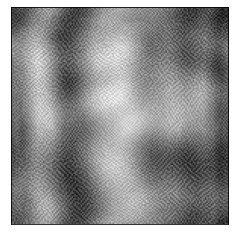

100/100 [==============================] - 2s 20ms/step - Score: -11.7442 - TotalVariation2D: 7.2110 - Norm: 9.7649


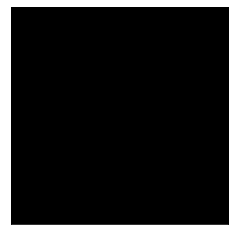

100/100 [==============================] - 2s 20ms/step - Score: 627.0164 - TotalVariation2D: 7.4559 - Norm: 94.1504


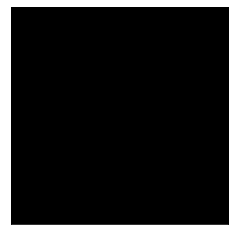

100/100 [==============================] - 2s 20ms/step - Score: 319.0279 - TotalVariation2D: 6.6921 - Norm: 40.3452


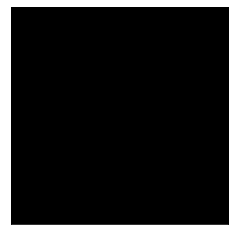

In [ ]:
activation_maximization = ActivationMaximization(
    model_deeper,
    model_modifier=[ExtractIntermediateLayer('conv2d'),ReplaceToLinear()],
    clone=False)

for idx in range(16):
  activations = activation_maximization(
      CategoricalScore(idx),
      steps=100,
      input_modifiers=[Jitter(jitter=16), Rotate2D(degree=1)],
      regularizers=[TotalVariation2D(weight=1.0),
                    Norm(weight=0.3, p=1)],
      optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
      callbacks=[Progress()])
  plt.imshow(activations[0][:,:,0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()

20/20 [==============================] - 0s 19ms/step - Score: -127.9358 - TotalVariation2D: 27.0151 - Norm: 16.3785


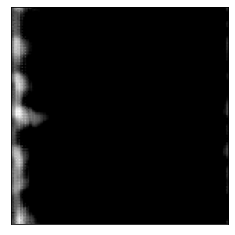

20/20 [==============================] - 0s 20ms/step - Score: -84.5583 - TotalVariation2D: 27.5481 - Norm: 18.9936


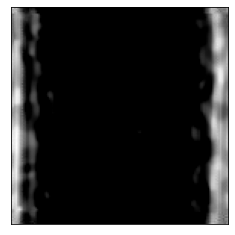

20/20 [==============================] - 0s 20ms/step - Score: -225.2012 - TotalVariation2D: 23.6693 - Norm: 19.6151


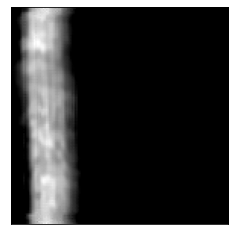

20/20 [==============================] - 0s 19ms/step - Score: -295.9915 - TotalVariation2D: 17.7446 - Norm: 17.5496


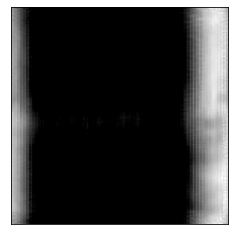

20/20 [==============================] - 0s 21ms/step - Score: -359.9057 - TotalVariation2D: 17.4733 - Norm: 23.2769


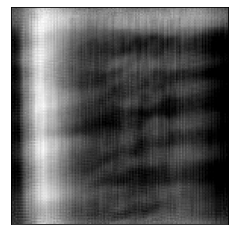

20/20 [==============================] - 0s 20ms/step - Score: -181.4229 - TotalVariation2D: 23.6721 - Norm: 15.9985


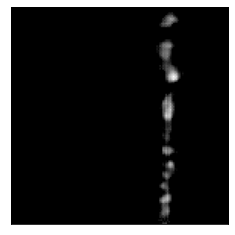

20/20 [==============================] - 0s 21ms/step - Score: -64.8520 - TotalVariation2D: 34.4449 - Norm: 19.8683


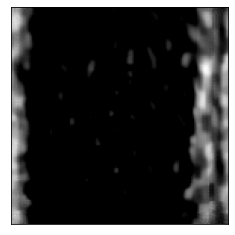

20/20 [==============================] - 0s 21ms/step - Score: -366.7258 - TotalVariation2D: 26.1081 - Norm: 15.0195


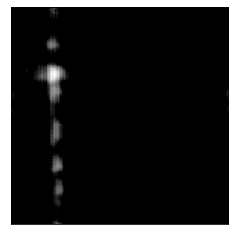

20/20 [==============================] - 0s 21ms/step - Score: -570.1954 - TotalVariation2D: 21.2812 - Norm: 15.1349


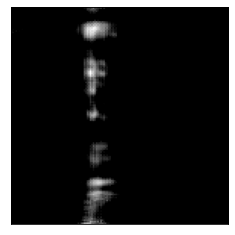

20/20 [==============================] - 0s 21ms/step - Score: -394.3859 - TotalVariation2D: 24.6116 - Norm: 16.1739


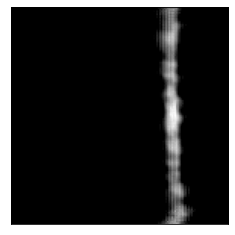

20/20 [==============================] - 0s 21ms/step - Score: -215.3574 - TotalVariation2D: 23.9708 - Norm: 15.4895


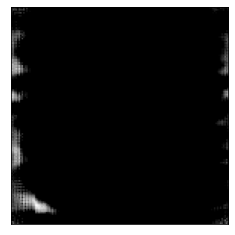

20/20 [==============================] - 0s 20ms/step - Score: 225.6712 - TotalVariation2D: 30.5763 - Norm: 16.8021


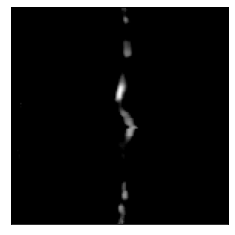

20/20 [==============================] - 0s 20ms/step - Score: -200.6508 - TotalVariation2D: 17.8098 - Norm: 15.1618


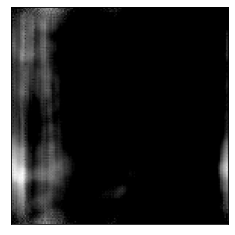

20/20 [==============================] - 0s 21ms/step - Score: -78.7077 - TotalVariation2D: 17.9626 - Norm: 17.4895


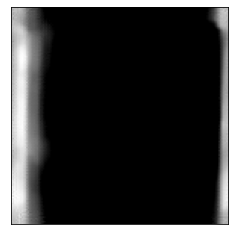

20/20 [==============================] - 0s 21ms/step - Score: -403.0714 - TotalVariation2D: 21.3159 - Norm: 18.9376


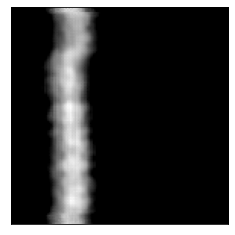

20/20 [==============================] - 0s 20ms/step - Score: -326.0316 - TotalVariation2D: 23.9350 - Norm: 15.5104


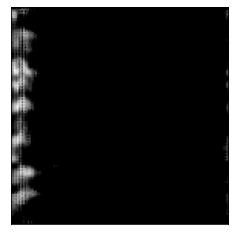

In [ ]:
activation_maximization = ActivationMaximization(
    model_deeper,
    model_modifier=[ExtractIntermediateLayer('conv2d_1'),ReplaceToLinear()],
    clone=False)
for idx in range(16):
  activations = activation_maximization(
      CategoricalScore(idx),
      steps=20,
      input_modifiers=[Jitter(jitter=16), Rotate2D(degree=1)],
      regularizers=[TotalVariation2D(weight=1.0),
                    Norm(weight=0.3, p=1)],
      optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
      callbacks=[Progress()])
  plt.imshow(activations[0][:,:,0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()

Results: It seems the easiest symmetry is vertical symmetry.

# VARIUOS ACTIVATION TEST

In [7]:
model_swish: tf.keras.models.Model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=24, kernel_size=(11, 11), activation='swish'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(5, 5), activation='swish'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_swish.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [8]:
history_swish = model_swish.fit(
    train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=valid_generator
    )

Epoch 1/15
268/268 [==============================] - 8118s 30s/step - loss: 5.9542 - mean_squared_error: 0.7159 - mean_absolute_error: 0.6335 - val_loss: 3.7734 - val_mean_squared_error: 0.3222 - val_mean_absolute_error: 0.4613
Epoch 2/15
268/268 [==============================] - 29s 109ms/step - loss: 3.8564 - mean_squared_error: 0.4390 - mean_absolute_error: 0.5194 - val_loss: 2.7550 - val_mean_squared_error: 0.3209 - val_mean_absolute_error: 0.4396
Epoch 3/15
268/268 [==============================] - 29s 108ms/step - loss: 3.7201 - mean_squared_error: 0.4277 - mean_absolute_error: 0.5115 - val_loss: 2.8574 - val_mean_squared_error: 0.3088 - val_mean_absolute_error: 0.4300
Epoch 4/15
268/268 [==============================] - 30s 111ms/step - loss: 3.6639 - mean_squared_error: 0.4131 - mean_absolute_error: 0.5022 - val_loss: 2.7828 - val_mean_squared_error: 0.3085 - val_mean_absolute_error: 0.4315
Epoch 5/15
268/268 [==============================] - 30s 111ms/step - loss: 3.6720 

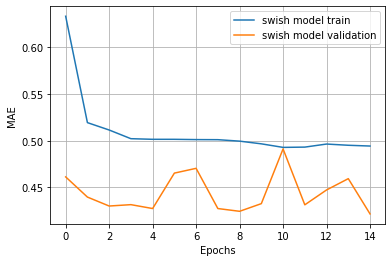

In [9]:
compare_history([history_swish], ["swish model"], [15])

Results: activation function barely changes anything.